## Video Game Recommendation System

In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

### Importing and Transforming Dataset

The information used in the dataset was obtained from <a href="https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings">Video Game Sales with Ratings</a> in Kaggle, which were web scraped by Gregory Smith from VGChartz Video Games Sales.

In [386]:
video_games_df = pd.read_csv("./Dataset/Video Games Sales.csv")

print(f"No. of records: {video_games_df.shape}")
video_games_df.head(5)

No. of records: (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [387]:
video_games_filtered_df = video_games_df.drop(['Publisher', 'Developer', 'Year_of_Release', 'User_Count', 'Critic_Count', 
                                               'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], axis=1)
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  8137 non-null   float64
 4   User_Score    10015 non-null  object 
 5   Rating        9950 non-null   object 
dtypes: float64(1), object(5)
memory usage: 783.8+ KB


### Exploratory Data Analysis

Check for all missing values in the dataset

In [388]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Critic_Score    8582
Rating          6769
User_Score      6704
Name               2
Genre              2
Platform           0
dtype: int64

Replace any missing data in the `Rating` field with the term `Unknown`

In [389]:
video_games_filtered_df.fillna({'Rating' : 'Unknown'}, inplace=True)
print(f"Rating\t\t{video_games_filtered_df['Rating'].isna().sum()}")

Rating		0


Replace the missing and 'tbd' data in the `User_Score` and `Critic_score` field with `-1` value

In [390]:
video_games_filtered_df.fillna({'User_Score' : -1, 'Critic_Score' : -1}, inplace=True)
video_games_filtered_df[['User_Score', 'Critic_Score']].isna().sum()

User_Score      0
Critic_Score    0
dtype: int64

Drop all missing data in the `Name` and `Genre`

In [391]:
print(f'No. of records (before): {video_games_filtered_df.shape}')

video_games_filtered_df.dropna(subset=['Name', 'Genre'], axis=0, inplace=True)

print(f'No. of records (after): {video_games_filtered_df.shape}')

No. of records (before): (16719, 6)
No. of records (after): (16717, 6)


Check again if there are any features with missing values

In [392]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Name            0
Platform        0
Genre           0
Critic_Score    0
User_Score      0
Rating          0
dtype: int64

Examine the distribution of the data for the `Genre`, `Platform`, and `Rating` features

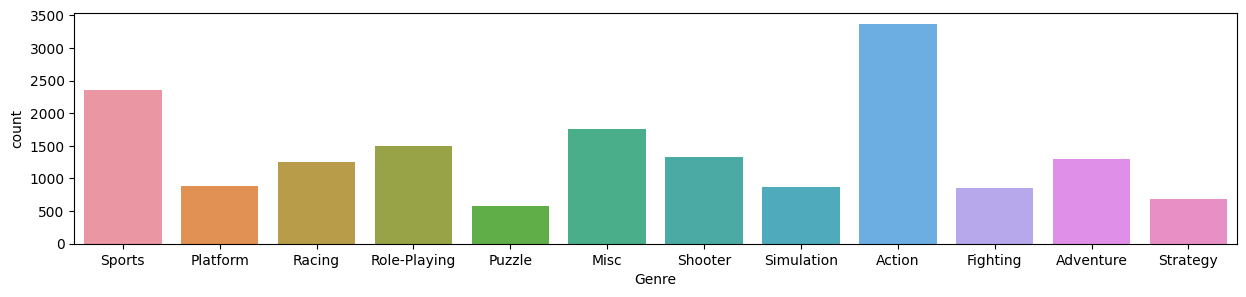

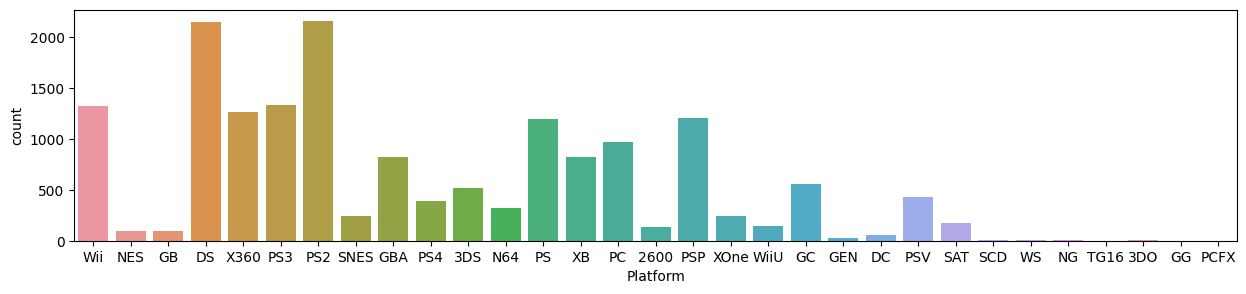

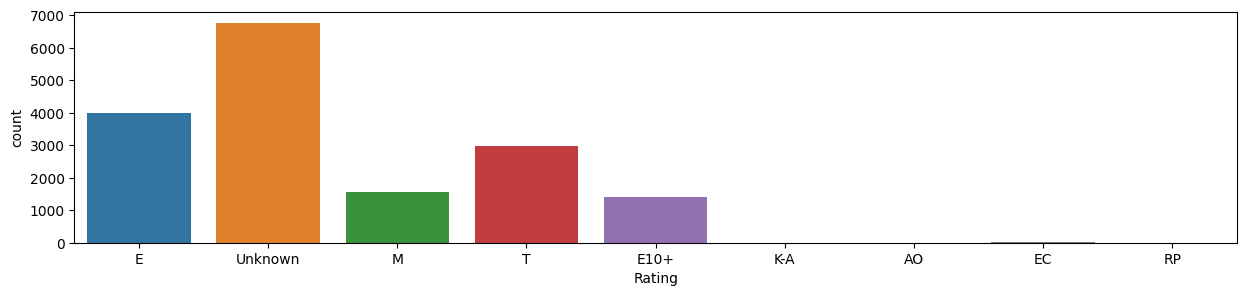

In [393]:
features = video_games_filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (15,3))
    sns.countplot(data=video_games_filtered_df, x=feature)

plt.show()

Examine `User_Score` then convert the data type from object to float. Replace the missing and 'tbd' data in the `User_Score` and `Critic_score` field with `-1` value

In [394]:
video_games_filtered_df['User_Score'].unique()

array(['8', -1, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [395]:
video_games_filtered_df['User_Score'] = video_games_filtered_df['User_Score'].replace('tbd', -1)
video_games_filtered_df['User_Score'].value_counts().sort_values(ascending=True)

9.7       1
0         1
0.3       2
9.6       2
1         2
       ... 
8.3     254
8.2     282
8       290
7.8     324
-1     9127
Name: User_Score, Length: 96, dtype: int64

In [396]:
video_games_filtered_df['User_Score'] = video_games_filtered_df['User_Score'].astype(float)
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16717 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16717 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  16717 non-null  float64
 4   User_Score    16717 non-null  float64
 5   Rating        16717 non-null  object 
dtypes: float64(2), object(4)
memory usage: 914.2+ KB


View the summary statistics of `User_Score` and `Critic_Score`

In [397]:
video_games_filtered_df.describe()

,Critic_Score,User_Score
count,16717.000000,16717.000000
mean,33.056769,2.689005
std,36.299296,4.169779
min,-1.000000,-1.000000
25%,-1.000000,-1.000000
50%,-1.000000,-1.000000
75%,70.000000,7.300000
max,98.000000,9.700000


Text(0.5, 0, 'Critic Score')

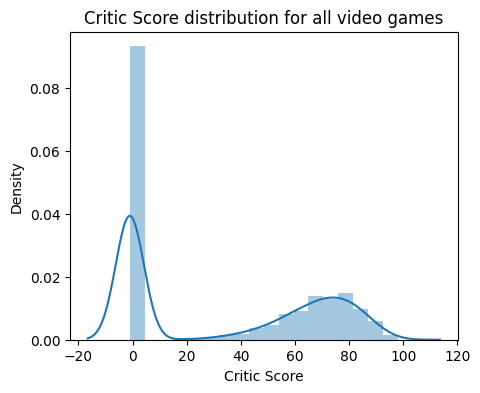

In [398]:
fig, ax = plt.subplots(figsize=[5, 4])
sns.distplot(video_games_filtered_df['Critic_Score'], ax=ax)
ax.set_title('Critic Score Distribution for all video games')
ax.set_xlabel('Critic Score')

Text(0.5, 0, 'User Score')

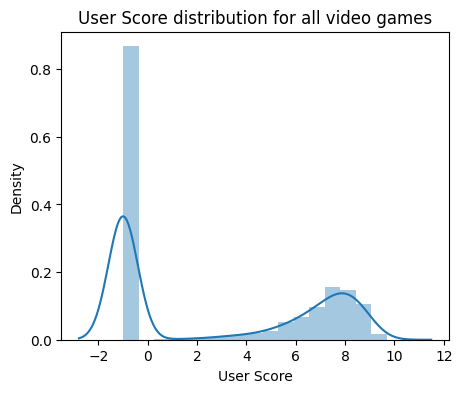

In [399]:
fig, ax = plt.subplots(figsize=[5, 4])
sns.distplot(video_games_filtered_df['User_Score'], ax=ax)
ax.set_title('User Score Distribution for all video games')
ax.set_xlabel('User Score')

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Critic Scores')]

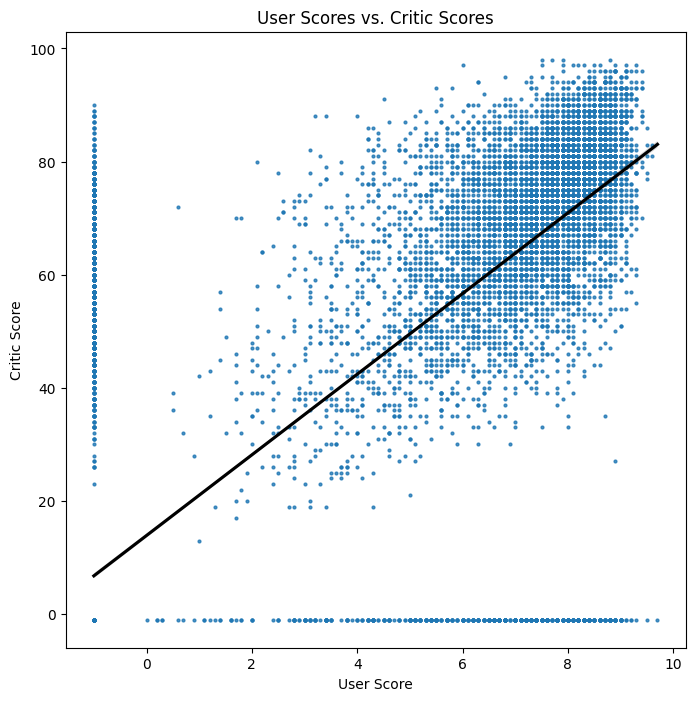

In [408]:
plt.figure(figsize=(8, 8))
plt.ticklabel_format(style='plain')
ax = sns.regplot(x=video_games_filtered_df['User_Score'], y=video_games_filtered_df['Critic_Score'], line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Critic Scores")

Create bin categories for `Critic_Score` and `User_Score`
- Unknown : -1
- Poor : between 0 and 2 (`User_Score`) | between 0 and 20 (`Critic_Score`)
- Fair : between 2 and 4 (`User_Score`) | between 20 and 40 (`Critic_Score`)
- Good : between 4 and 6 (`User_Score`) | between 40 and 60 (`Critic_Score`)
- Very Good : between 6 and 8 (`User_Score`) | between 60 and 80 (`Critic_Score`)
- Excellent : between 8 and 10 (`User_Score`) | between 80 and 100 (`Critic_Score`)

In [400]:
video_games_filtered_df['User_Score_Category'] = "Unknown"
video_games_filtered_df['User_Score_Category'] = np.where((video_games_filtered_df['User_Score'] >= 0) & (video_games_filtered_df['User_Score'] <= 2), 
                                                          "Poor", 
                                                          video_games_filtered_df['User_Score_Category'])
video_games_filtered_df['User_Score_Category'] = np.where((video_games_filtered_df['User_Score'] > 2) & (video_games_filtered_df['User_Score'] <= 4), 
                                                          "Fair", 
                                                          video_games_filtered_df['User_Score_Category'])
video_games_filtered_df['User_Score_Category'] = np.where((video_games_filtered_df['User_Score'] > 4) & (video_games_filtered_df['User_Score'] <= 6), 
                                                          "Good", 
                                                          video_games_filtered_df['User_Score_Category'])
video_games_filtered_df['User_Score_Category'] = np.where((video_games_filtered_df['User_Score'] > 6) & (video_games_filtered_df['User_Score'] <= 8), 
                                                          "Very Good", 
                                                          video_games_filtered_df['User_Score_Category'])
video_games_filtered_df['User_Score_Category'] = np.where((video_games_filtered_df['User_Score'] > 8) & (video_games_filtered_df['User_Score'] <= 10), 
                                                          "Excellent", 
                                                          video_games_filtered_df['User_Score_Category'])

video_games_filtered_df['User_Score_Category'].value_counts()

Unknown      9127
Very Good    3775
Excellent    2298
Good         1144
Fair          313
Poor           60
Name: User_Score_Category, dtype: int64

In [401]:
video_games_filtered_df['Critic_Score_Category'] = "Unknown"
video_games_filtered_df['Critic_Score_Category'] = np.where((video_games_filtered_df['Critic_Score'] >= 0) & (video_games_filtered_df['Critic_Score'] <= 20), 
                                                          "Poor", 
                                                          video_games_filtered_df['Critic_Score_Category'])
video_games_filtered_df['Critic_Score_Category'] = np.where((video_games_filtered_df['Critic_Score'] > 20) & (video_games_filtered_df['Critic_Score'] <= 40), 
                                                          "Fair", 
                                                          video_games_filtered_df['Critic_Score_Category'])
video_games_filtered_df['Critic_Score_Category'] = np.where((video_games_filtered_df['Critic_Score'] > 40) & (video_games_filtered_df['Critic_Score'] <= 60), 
                                                          "Good", 
                                                          video_games_filtered_df['Critic_Score_Category'])
video_games_filtered_df['Critic_Score_Category'] = np.where((video_games_filtered_df['Critic_Score'] > 60) & (video_games_filtered_df['Critic_Score'] <= 80), 
                                                          "Very Good", 
                                                          video_games_filtered_df['Critic_Score_Category'])
video_games_filtered_df['Critic_Score_Category'] = np.where((video_games_filtered_df['Critic_Score'] > 80) & (video_games_filtered_df['Critic_Score'] <= 100), 
                                                          "Excellent", 
                                                          video_games_filtered_df['Critic_Score_Category'])

video_games_filtered_df['Critic_Score_Category'].value_counts()

Unknown      8580
Very Good    4293
Excellent    1775
Good         1759
Fair          299
Poor           11
Name: Critic_Score_Category, dtype: int64